In [2]:
import matplotlib.pyplot as plt
import gym
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

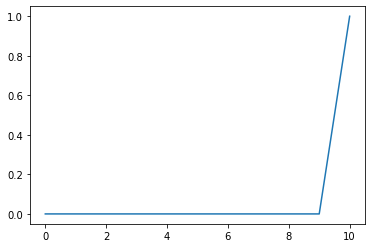

In [66]:
N = 10

b0 = np.zeros(N+1)
b0[N] = 1
final_rwd = 10

env = gym.make("gym_basic:wireless-v0")
env.customize(N, b0, final_rwd)
plt.plot(env.belief)
plt.show()

In [67]:
# the noise objects for DDPG
n_actions = env.action_space.shape[-1]
param_noise = None
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(.5) * np.ones(n_actions))

model = DDPG("MlpPolicy", env, verbose=1, action_noise=action_noise)
model.learn(total_timesteps=100000)
model.save("ddpg_wsn")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 89       |
|    ep_rew_mean     | -54.2    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 312      |
|    time_elapsed    | 1        |
|    total_timesteps | 356      |
| train/             |          |
|    actor_loss      | 1.08     |
|    critic_loss     | 0.00827  |
|    learning_rate   | 0.001    |
|    n_updates       | 287      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 55.2     |
|    ep_rew_mean     | -32.8    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 311      |
|    time_elapsed    | 1        |
|    total_timesteps | 442      |
| train/             |          |
|    actor_loss      | 1.36     |
|    critic_loss     |

In [68]:
del model # remove to demonstrate saving and loading

model = DDPG.load("ddpg_wsn")

1.661
64.626 40.12398439836204
76.95785655494807 79.8969280918771


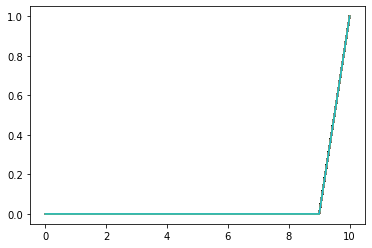

In [69]:
trials = 1000
steps = np.zeros(trials)
cumR = np.zeros(trials)
pi = np.zeros([trials, 200])
unfinished = np.zeros(trials)
for trial in range(trials):
    t = 0
    done = False
    belief = env.reset()
    plt.plot(np.arange(0, N+1), belief)
    R = 0
    states = []
    while not done:
        """
        if np.mod(t + 1, 1)==0:
            plt.plot(np.arange(0, N+1), belief)
        """
        action, _belief = model.predict(belief)
        belief, rwd, done, _ = env.step(action)
        R += rwd
        pi[trial, t] = action
        states.append(env.state)
        t += 1
        if t>10*N:
            unfinished[trial] = env.state
            break

    steps[trial] = t
    cumR[trial] = R
    """
    print(t, R)
    plt.xlabel('state s')
    plt.ylabel('p(s)')
    plt.title(f'Solved in {t} steps')
    plt.show()
    """
print(np.mean(unfinished))
print(np.mean(steps), np.std(steps))
print(np.mean(cumR), np.std(cumR))

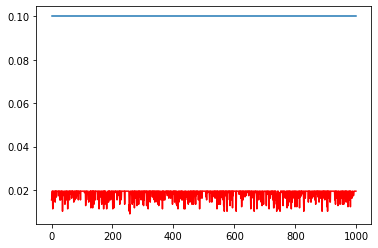

In [70]:
plt.plot(np.mean(pi, axis=1), 'r')
plt.plot(1/N * np.ones(len(pi)))
plt.show()

In [71]:
trials = 100
steps = np.zeros(trials)
cumR = np.zeros(trials)
action = 1/N
for trial in range(trials):
    t = 0
    done = False
    belief = env.reset()
    R = 0
    pi = []
    states = []
    while not done:
        """
        if np.mod(t + 1, 1)==0:
            plt.plot(np.arange(0, N+1), belief)
        """
        belief, rwd, done, _ = env.step(action)
        action = 1/env.state-0.000001
        R += rwd
        pi.append(action)
        states.append(env.state)
        t += 1
        if t>10*N:
            break

    steps[trial] = t
    cumR[trial] = R
    """
    print(t, R)
    plt.xlabel('state s')
    plt.ylabel('p(s)')
    plt.title(f'Solved in {t} steps')
    plt.show()
    """
print(np.mean(steps), np.std(steps))
print(np.mean(cumR), np.std(cumR))

23.32 5.407180411267965
-7.303347039497169 7.3981876568963525


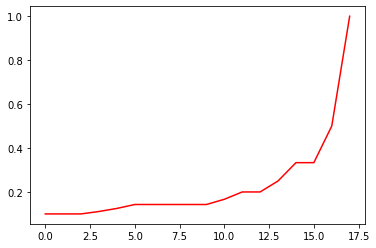

In [72]:
plt.plot(pi, 'r')

In [73]:
trials = 1000
steps = np.zeros(trials)
cumR = np.zeros(trials)
action = 1/N
for trial in range(trials):
    t = 0
    done = False
    belief = env.reset()
    R = 0
    pi = []
    states = []
    a_space = [0.99999999] + [1/i for i in range(2, N+1)]
    action = 1/N
    while not done:
        """
        if np.mod(t + 1, 1)==0:
            plt.plot(np.arange(0, N+1), belief)
        """
        belief, rwd, done, _ = env.step(action)
        # Action that maximizes prob of successful tx
        adx = np.argmax([sum([(i * a * (1-a)**(i-1))*belief[i] for i in range(N+1)]) for a in a_space])
        action = a_space[adx]
        R += rwd
        pi.append(action)
        states.append(env.state)
        t += 1
        if t>10*N:
            break

    steps[trial] = t
    cumR[trial] = R
    """
    print(t, R)
    plt.xlabel('state s')
    plt.ylabel('p(s)')
    plt.title(f'Solved in {t} steps')
    plt.show()
    """
print(np.mean(steps), np.std(steps))
print(np.mean(cumR), np.std(cumR))

23.806 7.800407938050419
-6.515132465018207 5.704989676939188


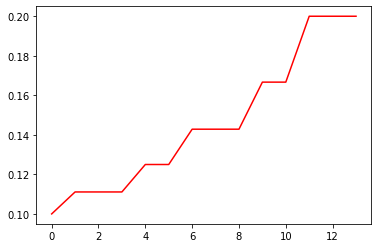

In [74]:
plt.plot(pi, 'r')

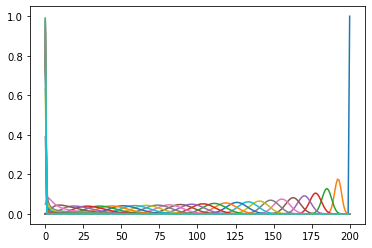

In [12]:
import matplotlib.pyplot as plt
import gym
import numpy as np

N = 200

b0 = np.zeros(N+1)
b0[N] = 1
final_rwd = 10

env = gym.make("gym_basic:wireless-v0")
env.customize(N, b0, final_rwd)
plt.plot(env.belief)

t = 0
done = False
belief = env.reset()
R = 0
a_space = [0.99999999] + [1/i for i in range(2, N+1)]
action = 1/N
beliefs_story = []
while not done:
    belief, rwd, done, _ = env.step(action)
    # Action that maximizes prob of successful tx
    adx = np.argmax([sum([(i * a * (1-a)**(i-1))*belief[i] for i in range(N+1)]) for a in a_space])
    action = a_space[adx]
    R += rwd
    beliefs_story.append(belief)
    t += 1
    if t>10*N:
        break

for idx, belief in enumerate(beliefs_story):
    if np.mod(idx+1, 20)==0:
        plt.plot(belief)